In [1]:
# default_exp full_alphabet_optim
%load_ext autoreload
%autoreload 2

# Optimising the Full Alphabet

> Optimisation using the whole alphabet as a batch.

In [2]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Font Learner Factory

In [3]:
#export

def create_font_learner(
    ocr_model = None, 
    ocr_learner = None, 
    vocab = VOCAB_UC,
    letters = None,
    folder = None, 
    normalise = False, 
    epoch_len = 1,
    vector_class = SansSerifFontRL, 
    input_shape = None, 
    n_colors_out = 1, 
    eps = None, 
    lr = 1e-2, 
    debug = False, 
    cbs = None, 
    seed = None, 
    init_range = 2.,
    samples = None,
    bs = None,
    ) -> VectorLearner:
    """A factory function for creating a `VectorLearner` for full font optimisation."""

    if eps is not None: warn(f"Using eps {eps}")
    if ocr_model is not None and input_shape is None:
        input_shape = (28,28)
        warn(f"Using default input_shape: {input_shape}")
    
    if ocr_model is None: ocr_model = ocr_learner.model
    if vocab is None: vocab = get_vocab(ocr_learner)

    raster_norm = ocr_learner.dls.train.after_batch[1] if normalise else None

    if input_shape is None:
        ocr_img = ocr_learner.dls.train_ds[0][0]
        canvas_width = ocr_img.width
        canvas_height = ocr_img.height
    else: canvas_width, canvas_height = input_shape

    def get_dl(): return LetterDL.from_vocab(vocab, epoch_len=epoch_len, bs=bs) if letters is None else \
                         LetterDL(vocab=vocab, letters=letters, epoch_len=epoch_len, bs=bs)
    dls = DataLoaders(get_dl(), get_dl())

    image_saver = ImageSaver(folder=folder) if folder is not None else None
    render_layer = vector_class(vocab=vocab,
                                raster_norm=raster_norm, 
                                rendered_callback=image_saver,
                                canvas_width=canvas_width, 
                                canvas_height=canvas_height,
                                n_colors_out=n_colors_out,
                                seed=seed,
                                eps=eps,
                                init_range=init_range,
                                samples=samples)
    if debug: render_layer.debug = debug
    font_model = render_layer

    # Params will be added by Learner
    get_optim = partial(Adam, lr=lr,
                              mom=.5,
                              sqr_mom=.9,
                              wd=0.) # NB. Eps can be also modified

    loss = OCRAndParamLoss(ocr_model=ocr_model,
                           vector_model=render_layer,
                           debug=debug)

    vector_learner = VectorLearner(dls=dls,
                                   model=font_model,
                                   loss_func=loss,
                                   opt_func=get_optim,
                                   cbs=cbs,
                                   image_saver=image_saver)

    return vector_learner

def get_learner(seed=42, **kwargs):
    gc.collect()
    if 'ocr_model' not in locals() or ocr_model is None:
        ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                                df=get_combined_az_and_tmnist_df)
    cb = DebugCB(vocal=False)
    learner = create_font_learner(letters=None,
                                cbs=cb,
                                folder=None,
                                ocr_model=ocr_model,
                                n_colors_out=1,
                                lr=1e-2, 
                                init_range=2.,
                                seed=seed,
                                **kwargs)
    return learner

## Optimisation Utilities

In [5]:
DUMP_FOLDER = "results/test_9_whole_alphabet"
VARS_WO_DIV_ADAM_PATH = os.path.join(DUMP_FOLDER, "selected_variations_wo_div_adam.pkl")

class ParamRecorderCB(Callback):
    best: dict = None
    best_on = None
    last_best_loss = None
    results: list[dict] = []
    def __init__(self, max_epochs_after_best: int = None, *args, **kwargs):
        super(ParamRecorderCB, self).__init__(*args, **kwargs)
        store_attr("max_epochs_after_best")
    def before_fit(self):
        self.best_on = 0
        if self.best is None: self.last_best_loss = self.get_current_loss()
    def after_loss(self):
        if not self.training: return
        l  = self.loss.item()
        lr = self.opt.hypers[-1]["lr"]
        p  = self.get_param_dict()
        if not self.best or l < self.best["loss"]:
            self.best = dict(loss=l, lr=l, params=p)
            self.best_on = self.epoch
        elif self.max_epochs_after_best is not None and \
             self.epoch - self.best_on > self.max_epochs_after_best:
            raise CancelFitException()
    def after_fit(self):
        impr = self.last_best_loss - self.best["loss"]
        self.last_best_loss = self.best["loss"]
        impr_fr = impr / (self.last_best_loss + EPS)
        self.results.append(dict(impr=impr, 
                                 impr_fr=impr_fr,
                                 stopped_at=self.epoch,
                                 n_epochs=self.n_epoch,
                                 **self.best))
        print(f"Improvement {impr:.4f} ({impr_fr:.2%})")
    def reset_to_best(self):
        """Reset to the best saved parameters."""
        assert self.best
        self.load_param_dict(self.best["params"])

def fancy_fit_2(
    learner: VectorLearner,
    param_cb: ParamRecorderCB,
    epochs = 100,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 40,
    max_zero_iters = 2,
    max_epochs_after_best = 10
    ) -> list[dict]:
    """A fancier fitting algorithm, which tests picks the best epoch after
       fitting, resets to that and adjusts `lr` and `epochs` if needed."""
    old_max = param_cb.max_epochs_after_best
    param_cb.max_epochs_after_best = max_epochs_after_best
    last_zero = None
    for i in range(iters):
        clear()
        print(f"Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        res = param_cb.results[-1]
        if res["impr"] <= 0 or res["stopped_at"] < res["n_epochs"] - 1:
            param_cb.reset_to_best()
            if last_zero is None: last_zero = i
            if max_zero_iters is not None and i - last_zero > max_zero_iters: break
            lr        *= lr_factor
            epochs    += epoch_increment
        else: last_zero = None
    clear()
    param_cb.max_epochs_after_best = old_max
    return param_cb.results

def fancy_fit_2_variations(
    variations = 50,
    dump_folder = DUMP_FOLDER,
    filename = "variation_wo_divergence_v2_",
    bs = None,
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    def noop(*args): pass
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(seed=None, bs=bs)
        param_cb = ParamRecorderCB()
        self.add_cb(param_cb)
        self.recorder.logger = noop
        self.reset_parameters()
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        var_res = fancy_fit_2(self, param_cb, **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   self.get_param_dict(),
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters()
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def plot_variation_results(
    variations: list[dict],
    figsize = (6, 6),
    lim: float = None
    ) -> None:
    """Plot the results from `fancy_fit_2_variations`."""
    df = DataFrame(variations)
    if lim is None: lim = math.ceil(max(df.init_loss)) 
    init_med, final_med = np.median(df.init_loss), np.median(df.final_loss)
    impr_med = np.median((df.init_loss - df.final_loss) / df.init_loss)
    min_loss = df.final_loss.min()
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    ax.set_xlim(0, lim), ax.set_ylim(0, lim)
    ax.scatter(df.init_loss, df.final_loss)
    ax.scatter(init_med, final_med)
    plt.suptitle(f"Initial losses vs final losses\n(median in orange, median improvement {impr_med:.2%},\nmin loss {min_loss:.4f})")
    plt.xlabel(f"Initial loss"), plt.ylabel(f"Final loss")

def show_variation_renders(
    variations: Union[list[dict], DataFrame],
    n_cols = 4,
    fig_width = 14,
    ) -> plt.Figure:
    """Show the rendered images together with losses."""
    if type(variations) is list: variations = DataFrame(variations)
    variations = variations.sort_values(by="final_loss").reset_index()
    n_imgs = len(variations)
    n_rows = math.ceil(n_imgs / n_cols)
    _img = variations.iloc[0].img
    img_ratio = _img.height / _img.width
    fig_height = (fig_width / n_cols * img_ratio + .5) * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        if i >= n_imgs: break
        v = variations.iloc[i]
        ax.imshow(v.img)
        ax.set_title(f"Loss {v.final_loss:.4f}")
    plt.show()
    return fig

def avg_loss(
    learner,
    n = 20,
    return_list = False
    ) -> float:
    """Calc avg loss over `n` iterations."""
    losses = []
    for i in range(n): losses.append(learner.get_current_loss())
    return losses if return_list else sum(losses) / n

def print_losses(
    losses: Union[list, np.array], 
    msg = None
    ) -> None:
    """Print basic stats of losses."""
    if msg is not None: msg += ": "
    losses = np.array(losses)
    l_mean = losses.mean()
    l_std = losses.std()
    l_spread = losses.max() - losses.min()
    print(f"{msg}Mean: {l_mean:.4f} • SD: {l_std:.4f} ({l_std / l_mean:.1%}) • Spread {l_spread:.4f} ({l_spread / l_mean:.1%})")
    return(dict(mean=l_mean, std=l_std, spread=l_spread))

def get_individual_losses(
    learner,
    iters = 20
    ) -> np.array:
    """Get losses for individual letters. Mean over `iters`."""
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    losses = []
    for i in range(iters):
        v = learner.model(x)
        l = loss(v, y)
        losses.append([x.item() for x in l[0]])
    losses = np.array(losses)
    means = losses.mean(axis=0)
    return means

def plot_current_individual_losses(
    learner,
    **kwargs
    ) -> np.array:
    means = get_individual_losses(learner, **kwargs)
    letters = learner.vocab
    fig = plt.figure()
    ax = fig.add_subplot()
    line, = ax.plot(means)
    ax.set_xticks(range(len(letters)), labels=letters)
    return means

def try_params(
    learner,
    param = "Width, HNU",
    steps = 40,
    min = -4., max = 4., 
    loss_iters = 20
    ) -> DataFrame:
    """Try different param values and record individual letters losses (mean overs `loss_iters`)."""
    assert steps > 1
    self = learner
    lf = self.loss_func
    with debug(lf):
        model = self.model
        stats = []
        for i in range(steps):
            report("Trying params", prog = i / steps)
            v = min + (max - min) * i / (steps - 1)
            model.set_param(param, v)
            means = {f"loss_{k}": v for k, v in zip(learner.vocab, get_individual_losses(learner, iters=loss_iters))}
            d = {
                "value": model.get_param(param).item(), # There's a discrepancy between v and this
                "interpolated_value": model.get_param_value(param).item(),
                **means
                }
            stats.append(d)
    return DataFrame(stats)

## 10. Retry Fancy Fit

Retrying fancy fit now that we are using more samples.

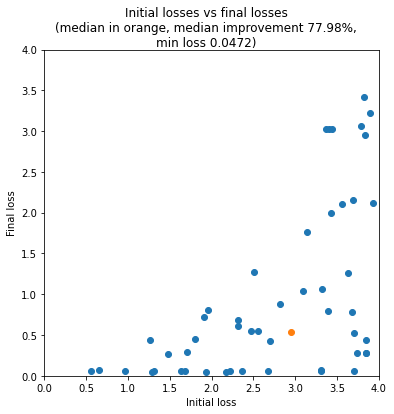

In [8]:
results_vars_smooth_fn = "variation_smooth_"
if False:
    results_vars_smooth = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .9,
        iters = 40,
        filename = results_vars_smooth_fn,
        # bs = len(VOCAB_UC) * 4
        )
results_vars_smooth_fn = os.path.join(DUMP_FOLDER, results_vars_smooth_fn)
# dump(results_vars_smooth, results_vars_smooth_fn)
results_vars_smooth = load(results_vars_smooth_fn)
plot_variation_results(results_vars_smooth, lim=4)

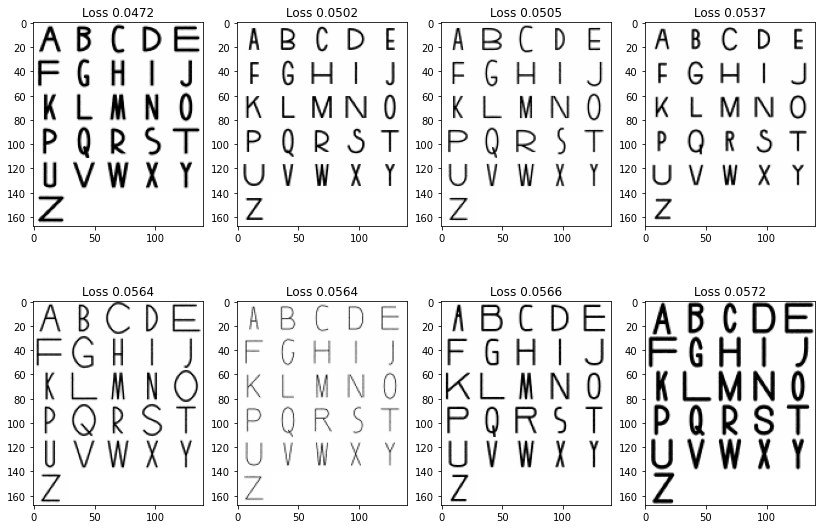

In [14]:
_ = show_variation_renders([x for x in results_vars_smooth if x["final_loss"] < .06])

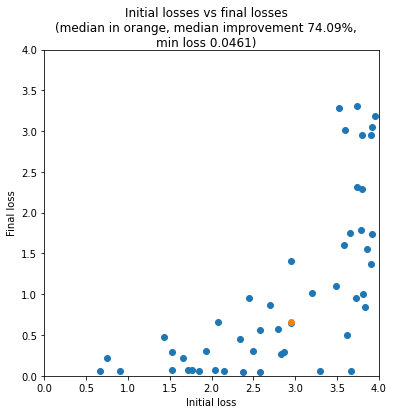

In [15]:
results_vars_smooth_2_fn = "variation_smooth_"
if False:
    results_vars_smooth_2 = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .9,
        iters = 40,
        filename = results_vars_smooth_2_fn,
        bs = len(VOCAB_UC) * 4
        )
results_vars_smooth_2_fn = os.path.join(DUMP_FOLDER, results_vars_smooth_2_fn)
# dump(results_vars_smooth_2, results_vars_smooth_2_fn)
results_vars_smooth_2 = load(results_vars_smooth_2_fn)
plot_variation_results(results_vars_smooth_2, lim=4)

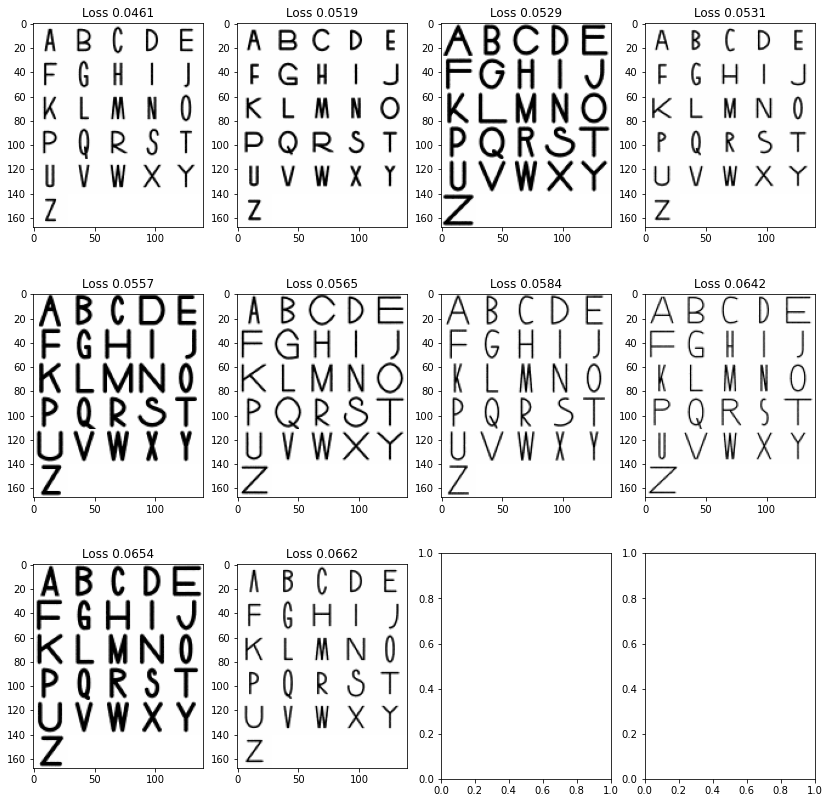

In [18]:
_ = show_variation_renders([x for x in results_vars_smooth_2 if x["final_loss"] < .07])

## 9. Interlude: Examine the Effect of Render Samples Parameter on Loss

We had a visual look at the effect of the samples parameter earlier, but let's see how it affects the loss noise.

Std for 4 samples


/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_7290/619515308.py:28: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


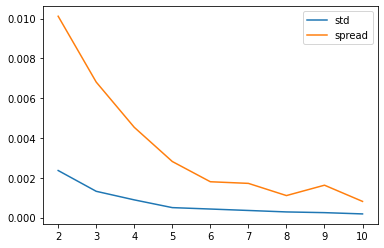

In [17]:
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)
learner = get_learner()
v = sel_vars_df.iloc[0]
learner.load_param_dict(v.final_params)
if False:
    sample_losses = []
    max_samples = 10
    for s in range(1, max_samples + 1):
        report(prog=s/(max_samples + 1))
        learner.model.samples = s
        l = learner.get_current_loss(iters=50, reduction=None)
        stats = print_losses(l, msg=f"Losses for samples {s}")
        sample_losses.append(dict(samples=s, **stats))
        # display(learner.render_letters(scale=3))
losses_df = DataFrame(sample_losses)
losses_df.index = range(1, len(losses_df) + 1)
losses_df.drop(["samples", "mean"], axis=1, inplace=True)
losses_df.iloc[1:].plot() # Drop the first (samples=1) as it messses up the range

Based on the results, it seems we should raise the number of samples from the current 4 to 6. Let's quickly time the effects of this on performance.

<AxesSubplot:>

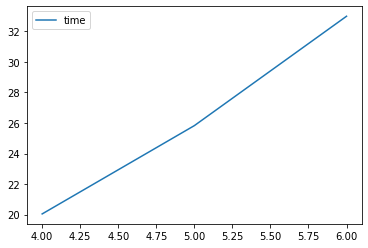

In [19]:
if False:
    sample_times = []
    iters = 100
    samples = (4, 5, 6)
    for s in samples:
        t0 = time.time()
        learner.model.samples = s
        l = learner.get_current_loss(iters=iters, reduction=None)
        sample_times.append(dict(samples=s, time=time.time() - t0))
times_df = DataFrame(sample_times)
times_df.index = samples
times_df.drop(["samples"], axis=1, inplace=True)
times_df.plot()

> The increase in processing time seems to be linear, so it should be okay to raise the default `samples` parameter to `6`. 

## 8. Interlude: Examining the Loss for Individual Letters

Even for the best result produced by the our fitting tests, there seems to be some space for improving individual letters.

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_3531/619515308.py:28: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


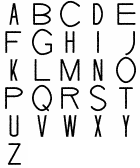

In [16]:
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)
learner = get_learner()
v = sel_vars_df.iloc[0]
learner.load_param_dict(v.final_params)
display(learner.render_letters())

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


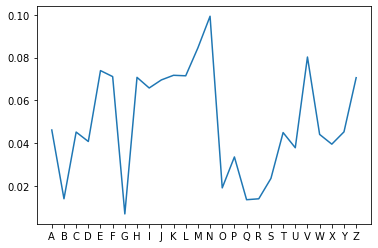

In [29]:
means = plot_current_individual_losses(learner)

It seems N is the worst performer. Let's see if by tweaking its private parameters there are any gains to be made.

In [30]:
params_n = [x for x in learner.model.param_names if re.search("N", x)]
idx_n = letters.index("N")
params_n, means[idx_n]

(['Width, HNU', 'Overshoot, AMNVW'], 0.09932682365179062)

In the end, the mean loss for HNU shows that the result of the previous optimisation for the value of `Width, HNU` (`-0.5008`) was, in fact, optimal with regard to the noise that was present then (the loss values below are means over 20 iterations).

In [44]:
# n_stats = try_params(learner)
print(f"Original value for Width, HNU: {sel_vars_df.iloc[0].final_params['Width, HNU']}")
print(n_stats.loss_H.min(), n_stats.loss_N.min(), n_stats.loss_U.min())
argmins = (n_stats.loss_H.argmin(), n_stats.loss_N.argmin(), n_stats.loss_U.argmin())
n_stats_range = n_stats.iloc[min(argmins):max(argmins)].copy()
n_stats_range["loss_HNU"] = (n_stats_range.loss_H + n_stats_range.loss_N + n_stats_range.loss_U) / 3
n_stats_range.filter(items=["value", "interpolated_value", "loss_H", "loss_N", "loss_U", "loss_HNU"], axis=1)

Original value for Width, HNU: -0.500807523727417
0.031438475288450715 0.0474864162504673 0.03936727102845907


,value,interpolated_value,loss_H,loss_N,loss_U,loss_HNU
16,-0.717949,0.361453,0.092645,0.047486,0.090502,0.076878
17,-0.512821,0.405806,0.076221,0.088812,0.039367,0.068133
18,-0.307692,0.452494,0.083300,0.122566,0.059677,0.088515
19,-0.102564,0.500662,0.080903,0.063511,0.050530,0.064981
20,0.102564,0.549338,0.080523,0.109249,0.060436,0.083403
21,0.307692,0.597506,0.067914,0.106434,0.044432,0.072927
22,0.512821,0.644194,0.061373,0.181647,0.052173,0.098398
23,0.717949,0.688547,0.057224,0.103256,0.059825,0.073435
24,0.923077,0.729885,0.051490,0.142428,0.078457,0.090792
25,1.128205,0.767732,0.050916,0.119015,0.076267,0.082066


## 7. Interlude: Examining the Loss

There is a lot of random jitter in the losses. We'll have a look at that now.

In [6]:
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)
learner = get_learner()
v = sel_vars_df.iloc[0]
learner.load_param_dict(v.final_params)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_3531/619515308.py:28: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:572: UserWarning: Are you sure you want to define bs when using from_vocab?
  if x in kwargs: warn(f"Are you sure you want to define {x} when using from_vocab?")


Doing iterations on the losses, we get the stats:

    Losses for 100 iterations: Mean: 0.0494 • SD: 0.0007 (1.5%) • Spread 0.0039 (7.9%)
    Losses for  20 iterations: Mean: 0.0495 • SD: 0.0007 (1.4%) • Spread 0.0026 (5.2%)
    Losses for  10 iterations: Mean: 0.0493 • SD: 0.0008 (1.6%) • Spread 0.0027 (5.5%)
    Losses for   5 iterations: Mean: 0.0498 • SD: 0.0009 (1.7%) • Spread 0.0022 (4.4%)

In [ ]:
if False:
    losses_100 = np.array(avg_loss(learner, n=100, return_list=True))
    print_losses(losses_100, msg="Losses for 100 iterations")
    losses_20 = np.array(avg_loss(learner, n=20, return_list=True))
    losses_10 = np.array(avg_loss(learner, n=10, return_list=True))
    losses_5 = np.array(avg_loss(learner, n=5, return_list=True))
    print_losses(losses_20, msg="Losses for 20 iterations")
    print_losses(losses_10, msg="Losses for 10 iterations")
    print_losses(losses_5, msg="Losses for 5 iterations")

Let's see if we can get the SD to go down if we increase the batch size. We see that by increasing it a bit, we can get modest reductions in SD and spread.

    Losses for bs 2 x vobab (50 iters): Mean: 0.0496 • SD: 0.0006 (1.2%) • Spread 0.0026 (5.3%)
    Losses for bs 3 x vobab (50 iters): Mean: 0.0495 • SD: 0.0005 (1.0%) • Spread 0.0023 (4.6%)
    Losses for bs 4 x vobab (50 iters): Mean: 0.0494 • SD: 0.0004 (0.8%) • Spread 0.0019 (3.8%)
    Losses for bs 5 x vobab (50 iters): Mean: 0.0495 • SD: 0.0004 (0.8%) • Spread 0.0018 (3.7%)
    Losses for bs 6 x vobab (50 iters): Mean: 0.0495 • SD: 0.0004 (0.8%) • Spread 0.0016 (3.2%)

In [9]:
if False:
    for i in range(2, 7):
        bs = len(VOCAB_UC) * i
        learner_big_bs = get_learner(bs=bs)
        v = sel_vars_df.iloc[0]
        learner_big_bs.load_param_dict(v.final_params)
        losses_big_bs = np.array(avg_loss(learner_big_bs, n=50, return_list=True))
        print_losses(losses_big_bs, msg=f"Losses for bs {i} x vobab (50 iters)")

Just to be sure, let's check that the OCR model is deterministic as it should be.

In [ ]:
def check_ocr_loss(learner, n=3):
    m = learner.model
    with eval_model(m):
        x, y = list(learner.dls.train)[0]
        p = m(x)
        losses = [learner.loss_func(p, y).item() for i in range(n)]
    spread = max(losses) - min(losses)
    if spread > 0: print(f"Losses are not same! Spread: {spread}")
    else: print("Losses are okay.")

check_ocr_loss(learner)

Losses are okay.


## 1. Testing Letter Models: Simple Adam

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_17804/933257450.py:27: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


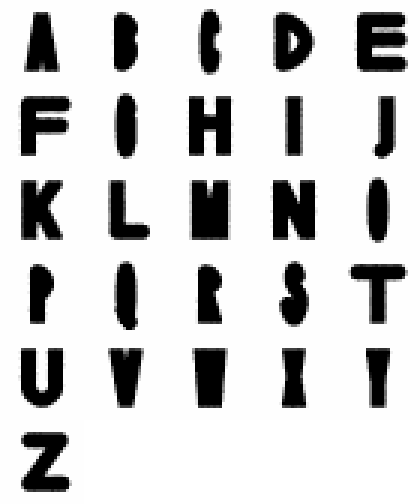

SansSerifFontRL with params:
   0 Height                            0.76 ( 0.70)
   1 Slant                             0.83 ( 0.39)
   2 Midline                          -0.23 ( 0.44)
   3 Stroke width                      0.92 ( 0.18)
   4 Bowl curvature                   -0.22 ( 0.45)
   5 Width, AV                         0.20 ( 0.57)
   6 Width, BPR                       -0.49 ( 0.41)
   7 Width, D                          0.59 ( 0.66)
   8 Width, EF                         0.88 ( 0.72)
   9 Width, CGOQ                      -0.73 ( 0.36)
  10 Width, HNU                        0.87 ( 0.72)
  11 Width, J                          0.19 ( 0.57)
  12 Width, K                          0.74 ( 0.69)
  13 Width, L                          0.14 ( 0.56)
  14 Width, M                          0.48 ( 0.64)
  15 Width, S                         -0.14 ( 0.49)
  16 Width, TZ                         0.77 ( 0.70)
  17 Width, W                          0.15 ( 0.56)
  18 Width, XY                     

In [78]:
# learn = None
learner = None
gc.collect()

if 'ocr_model' not in locals() or ocr_model is None:
    ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                               df=get_combined_az_and_tmnist_df)

cb = DebugCB(vocal=False)
learner = create_font_learner(letters=None,
                              cbs=cb,
                              folder="results/test_8_whole_alphabet_Adam",
                              ocr_model=ocr_model,
                              n_colors_out=1,
                              lr=1e-2, 
                              init_range=1., # Use smaller range to get values closer to mean
                              seed=42)

# learner.set_param("Aperture, CGS", -0)
display(learner.render_letters(scale=3))
learner.model

In [79]:
# torch.autograd.set_detect_anomaly(True)
# lr = 1e-1 # 5e-1, 2.5e-1, 1.5e-1
# learner.fit(10, lr=lr)
# learner.render_letters(scale=3)

## 2. Interlude: Check What Effect RenderFunction Samples Has

We'll check what effect changing the samples parameter has on the noise in the rendered letters. It seems raising that to 4 gets us nicer results. We'll update that to the defaults in fontlearner.

Samples: 1


/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_17804/933257450.py:27: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


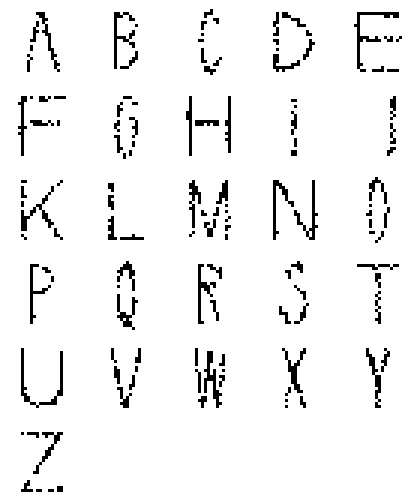

Samples: 2


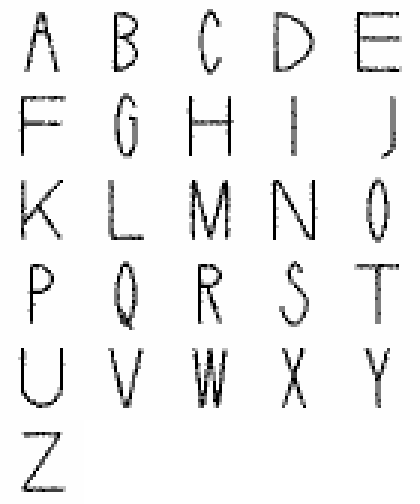

Samples: 3


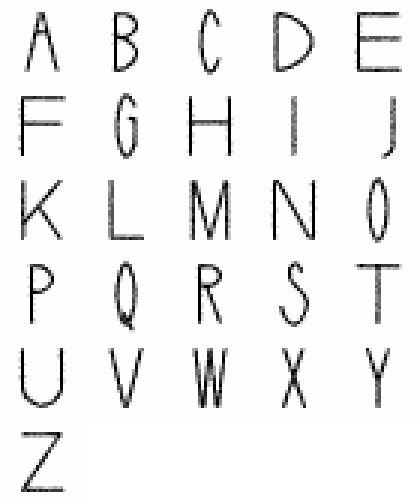

Samples: 4


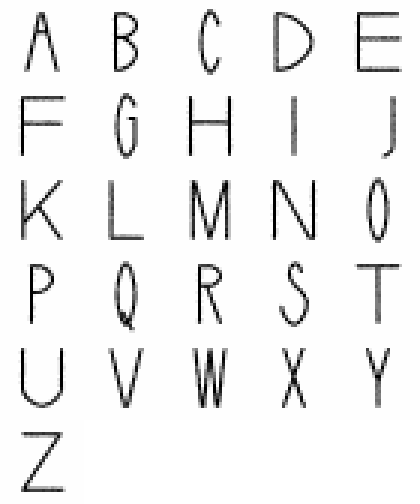

In [80]:
# learn = None
learner = None
gc.collect()

if 'ocr_model' not in locals() or ocr_model is None:
    ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                               df=get_combined_az_and_tmnist_df)

cb = DebugCB(vocal=False)
learner = create_font_learner(letters=None,
                            cbs=cb,
                            folder="results/test_8_whole_alphabet_Adam",
                            ocr_model=ocr_model,
                            n_colors_out=1,
                            lr=1e-2, 
                            init_range=1., # Use smaller range to get values closer to mean
                            seed=42)
learner.set_param("Stroke width", -2)
for s in range(1, 5):
    learner.model.samples = s
    print(f"Samples: {s}")
    display(learner.render_letters(scale=3))

## 3. Interlude 2: Checking the Loss Spread for Different Letters

Let's have a look at how the losses vary for different letters. The loss value we're using for optimiser steps is the mean of the losses over the whole alphabat, which might mask individual differences in losses.

In [81]:
# learn = None
learner = None
gc.collect()

if 'ocr_model' not in locals() or ocr_model is None:
    ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                               df=get_combined_az_and_tmnist_df)

cb = DebugCB(vocal=False)
learner = create_font_learner(letters=None,
                              cbs=cb,
                              folder="results/test_8_whole_alphabet_Adam",
                              ocr_model=ocr_model,
                              n_colors_out=1,
                              lr=1e-2, 
                              init_range=1., # Use smaller range to get values closer to mean
                              seed=42)

# learner.set_param("Aperture, CGS", -0)
# display(learner.render_letters(scale=3))
# learner.model

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_17804/933257450.py:27: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


In [82]:
def fit_and_calc_losses(
    learner,
    lrs = [5e-1, 2.5e-1, 1.5e-1],
    epochs = [10, 5, 5]
    ) -> list[Tensor]:
    """Fit for `epochs` using corresponding `lrs` and return individual OCR losses
       for each letter for each epoch group."""
    losses = []
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    def _calc_losses():
        v = learner.model(x)
        l = loss(v, y)
        losses.append([x.item() for x in l[0]])
    _calc_losses()
    for e,lr in zip(epochs, lrs):
        learner.fit(e, lr)
        _calc_losses()
    df = DataFrame(losses)
    df.columns = learner.vocab
    return df

# losses_df = fit_and_calc_losses(learner)

In [83]:
def plot_losses_per_letter(
    losses: DataFrame,
    skip_first = True,
    figsize=(10, 10)
    ) -> plt.Figure:
    # return losses.plot(figsize=figsize)
    letters = losses.columns
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    rows = losses.iloc[1:] if skip_first else losses
    for i, row in rows.iterrows(): 
        line, = ax.plot(row)
        line.set_label(f"Epoch group {i}")
    ax.set_xticks(range(len(letters)), labels=letters)
    fig.legend()
    fig.suptitle("Losses for for each letter after subsequent fitting sessions")
    return fig

# fig = plot_losses_per_letter(losses_df)

## 4. Optimise Without Divergence Loss

Check what results we get with a more proper optimisation procedure but still without adding a loss term for divergence.

In [85]:
def fancy_fit(
    iters = 20,
    n_epochs = 200, 
    lr_start = 2e-1,
    dump_folder = "results/test_9_whole_alphabet"
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    from IPython.display import clear_output
    def noop(*args): pass
    results = []
    for k in range(iters):
        self = None
        gc.collect()
        self = get_learner()
        self.recorder.logger = noop
        lr = lr_start
        self.reset_parameters()
        init_pars = self.get_param_dict()
        self.unfreeze_params()
        losses = []
        lrs = []
        for i in range(n_epochs):
            self.fit(1, lr)
            loss = self.recorder.losses[-1].item()
            losses.append(loss)
            lrs.append(lr)
            clear_output(wait=True)
            print(f"Iter {k + 1}/{iters} • Epoch {i + 1}/{n_epochs} • Lr {lr} • Loss {loss:.4}")
            if i > 10:
                loss_a = np.array(losses[-5:]).mean()
                loss_b = np.array(losses[-10:-5]).mean()
                if loss_b - loss_a < loss_a / 20: lr *= .92
        res = {
            "initial_params": init_pars,
            "final_params":   self.get_param_dict(),
            "losses":         losses,
            "lrs":            lrs,
            "img":            self.render_letters()
            }
        dump(res, os.path.join(dump_folder, f"variation_wo_divergence_{k}.pkl"))
        results.append(res)
    return results

dump_folder = "results/test_9_whole_alphabet"
pkl_file = os.path.join(dump_folder, f"variations_wo_divergence_all.pkl")
# variations = fancy_fit()
# dump(variations, pkl_file)
variations = load(pkl_file)

In [86]:
# variations_2 = learner.create_variations(
#     iters = 20,
#     epochs = [10,   10,   20,   20,   20], 
#     lrs =    [5e-1, 1e-1, 5e-2, 1e-2, 5e-3]
#     )
pkl_file_2 = os.path.join(dump_folder, f"variations_wo_divergence_all_nonfancy.pkl")
# dump(variations_2, pkl_file_2)
variations_2 = load(pkl_file_2)

In [87]:
def _get_loss(x): return x["losses"][-1] if "losses" in x else x["loss_at_end"]
def _get_params(x):
    p = x["final_params"] if "final_params" in x else x["param_values"]
    return {k: v for k, v in p} if type(p) is set else p

def show_variations(
    variations: list[dict]
    ) -> list:
    variations.sort(key=_get_loss)
    losses = np.array([_get_loss(x) for x in variations])
    print(f"Losses from {losses.min():.4} to {losses.max():.4}, median {np.median(losses):.4}, "
          f"mean {losses.mean():.4}, std {losses.std():.4}")
    for i in [0, 1, 2, 5, 10, 19]:
        v = variations[i]
        print(f"Variation #{i} • Loss {_get_loss(v):.4}")
        display(v["img"])
    return losses

Losses from 0.05449 to 3.367, median 0.2975, mean 0.6143, std 0.9534
Variation #0 • Loss 0.05449


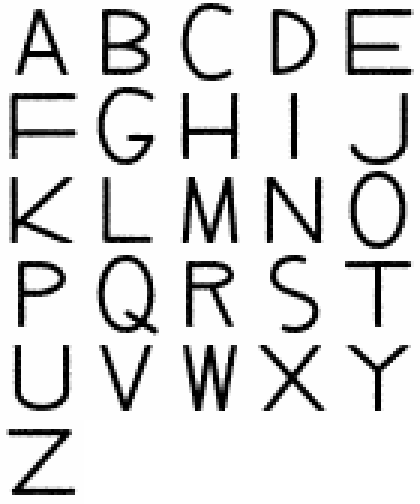

Variation #1 • Loss 0.05845


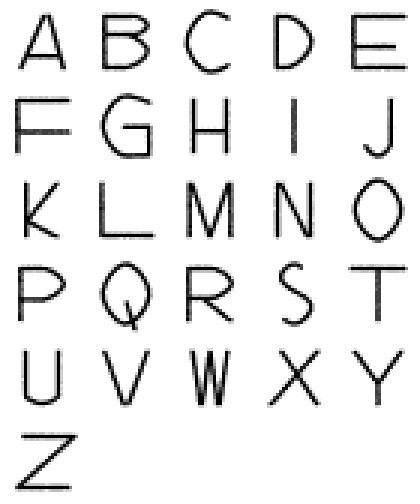

Variation #2 • Loss 0.05947


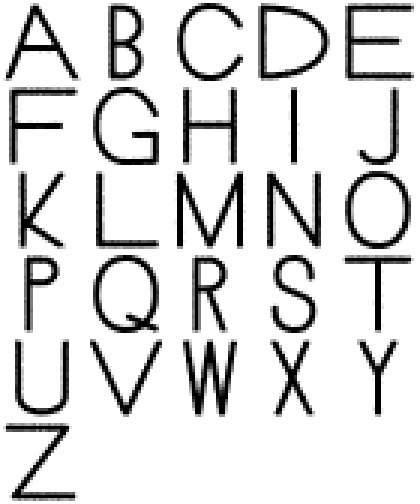

Variation #5 • Loss 0.07094


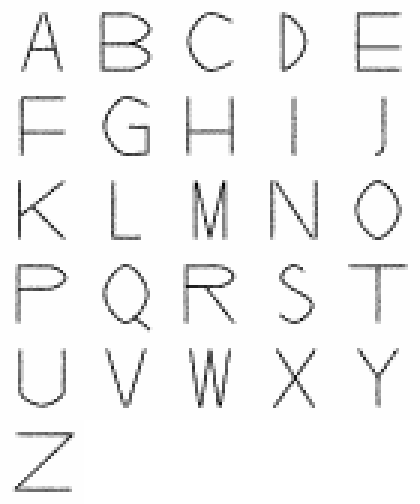

Variation #10 • Loss 0.3007


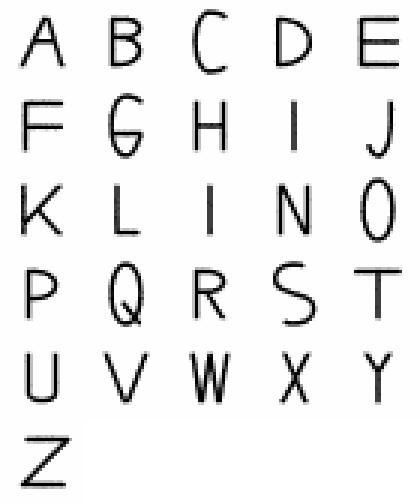

Variation #19 • Loss 3.367


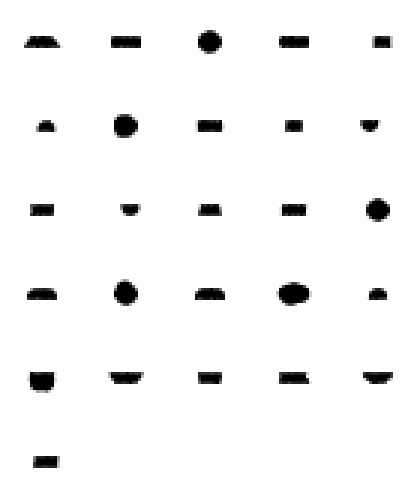

In [88]:
losses_2 = show_variations(variations_2)

Losses from 0.05353 to 0.2985, median 0.2796, mean 0.2406, std 0.08114
Variation #0 • Loss 0.05353


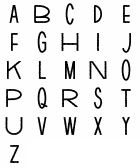

Variation #1 • Loss 0.05379


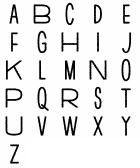

Variation #2 • Loss 0.0554


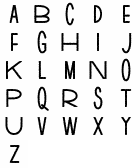

Variation #5 • Loss 0.234


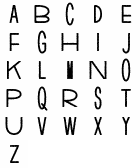

Variation #10 • Loss 0.2829


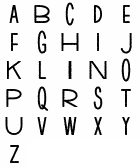

Variation #19 • Loss 0.2985


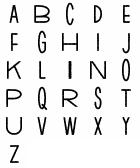

In [89]:
losses = show_variations(variations)

### Let's Try to Improve on the Best Results From the Variations

In [90]:
def _init_learner(variations, idx=0):
    v = sorted(variations, key=_get_loss)[idx]
    learner = get_learner()
    learner.load_param_dict(_get_params(v))
    return learner

def _try_fitting(variations, lr=1e-2, epochs=10, idx=0):
    learner = _init_learner(variations, idx=idx)
    orig_loss = learner.get_current_loss()
    learner.fit(epochs, lr)
    loss_delta = orig_loss - learner.get_current_loss()
    loss_fr = loss_delta / orig_loss
    print(("Improved" if loss_delta > 0 else "Worsened") + f" by {loss_fr:.2%}")
    return learner, loss_delta

def _try_fitting_all(variations, **kwargs):
    res = []
    for i in range(len(variations)):
        clear()
        print(f"Fitting variation {i + 1}/{len(variations)}")
        v = variations[i]
        orig_loss = _get_loss(v)
        learner, loss_delta = _try_fitting(variations, idx=i, **kwargs)
        res.append({
            "orig_loss":  orig_loss,
            "loss_delta": loss_delta,
            "loss_delta_fr": loss_delta / orig_loss,
            "final_params": learner.get_param_dict()
            })
    return res

First, try different learning rates. It seems like `5e-2` is the best, but the signal is not clear, which we can see from the huge SDs for the results over five iterations.

In [91]:
def try_lrs(variations):
    res = []
    iters = 5
    lrs = [1e-1, 5e-2, 2e-2, 1e-2, 8e-3, 5e-3, 2e-3, 1e-3, 8e-4, 2e-4]
    for lr in lrs:
        r = []
        for i in range(iters):
            learner, loss_delta = _try_fitting(variations, lr)
            r.append(loss_delta)
            from IPython.display import clear_output
            clear_output()
        res.append((lr, r))
    res_stats = []
    for lr, l in res:
        la = np.array(l)
        res_stats.append({
            "lr": lr,
            "loss_avg":    la.mean(),
            "loss_sd":     la.std(),
            "loss_sd_fr":  la.std() / la.mean(),
            "loss_min":    la.min(),
            "loss_max":    la.max()
            })
    res_stats_df = DataFrame(res_stats)
    return res_stats_df

# res_stats_df = try_lrs(variations)
res_stats_fn = os.path.join(dump_folder, "res_stats_df")
# dump(res_stats_df, res_stats_fn)
res_stats_df = load(res_stats_fn)
res_stats_df

,lr,loss_avg,loss_sd,loss_sd_fr,loss_min,loss_max
0,0.1000,-0.000766,0.000974,-1.271541,-0.001863,0.000523
1,0.0500,0.001337,0.000989,0.740345,-0.000186,0.002728
2,0.0200,-0.000431,0.001063,-2.469354,-0.002502,0.000552
3,0.0100,-0.000217,0.000963,-4.440430,-0.001862,0.000788
4,0.0080,0.000756,0.000998,1.319768,-0.000700,0.002280
5,0.0050,-0.000081,0.000635,-7.871805,-0.000762,0.001027
6,0.0020,-0.001226,0.001053,-0.858795,-0.002872,0.000038
7,0.0010,-0.000608,0.001303,-2.142964,-0.001835,0.001748
8,0.0008,-0.001502,0.000840,-0.559337,-0.002542,-0.000162
9,0.0002,-0.000020,0.000737,-35.941242,-0.001211,0.000791


Next, let's see what effect the number of epochs has.

In [92]:
def try_epochs(variations):
    res = []
    iters = 5
    lr = 5e-2
    epochs = [x * 10 for x in range(1, 11)]
    for e in epochs:
        r = []
        for i in range(iters):
            learner, loss_delta = _try_fitting(variations, lr=lr, epochs=e)
            r.append(loss_delta)
            from IPython.display import clear_output
            clear_output()
        res.append((e, r))
    res_stats = []
    for e, l in res:
        la = np.array(l)
        res_stats.append({
            "epochs": e,
            "lr":     lr,
            "loss_avg":    la.mean(),
            "loss_sd":     la.std(),
            "loss_sd_fr":  la.std() / la.mean(),
            "loss_min":    la.min(),
            "loss_max":    la.max()
            })
    return DataFrame(res_stats)

# res_stats_2_df = try_epochs(variations)
res_stats_2_fn = os.path.join(dump_folder, "res_stats_2_df")
# dump(res_stats_2_df, res_stats_2_fn)
res_stats_2_df = load(res_stats_2_fn)
res_stats_2_df

,epochs,lr,loss_avg,loss_sd,loss_sd_fr,loss_min,loss_max
0,10,0.05,0.000659,0.000512,0.776460,-0.000013,0.001452
1,20,0.05,0.000860,0.001034,1.202606,-0.000990,0.002183
2,30,0.05,0.001107,0.001090,0.985309,-0.000253,0.002783
3,40,0.05,0.001588,0.001650,1.039119,-0.001684,0.002761
4,50,0.05,-0.000109,0.000818,-7.534072,-0.001674,0.000638
5,60,0.05,0.001189,0.000705,0.592820,0.000600,0.002522
6,70,0.05,0.000318,0.001083,3.403913,-0.001167,0.002156
7,80,0.05,0.001043,0.001062,1.018528,-0.001053,0.001803
8,90,0.05,0.000987,0.001314,1.331437,-0.001013,0.002826
9,100,0.05,0.001616,0.000699,0.432494,0.000268,0.002272


Let's plot the results for epochs. The results aren't very clear, but it seems that the spreads are lower and averages improvements in loss higher for 60–100 epochs.

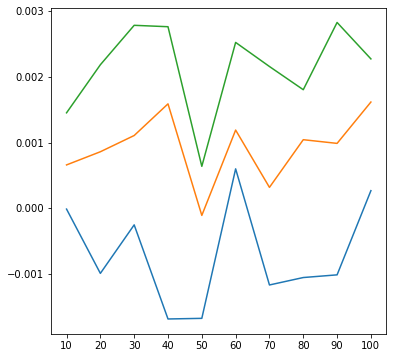

In [93]:
fig, ax = plt.subplots(figsize=(6,6))
ax1 = plt.plot(res_stats_2_df.loss_min)
ax2 = plt.plot(res_stats_2_df.loss_avg)
ax3 = plt.plot(res_stats_2_df.loss_max)
_ = ax.set_xticks(range(len(res_stats_2_df)), res_stats_2_df.epochs)

### Try Improving All Variations

Let's see if we can improve upon all of the variation produced earlier by training more. From the plot, we can seen that almost all variaties did benefit from further training, even by 50%. There is, however, some noise in the loss calculations, which are not smoothed, so we should take a pinch of salt with these results.

Notably, the two cases where the loss was very high, little improvement is discernible, and they seem to be in the poor initial parameters.

In [94]:
def do_try_all():
    res_all_vars = _try_fitting_all(variations_2, lr = 5e-2, epochs=100)
    res_all_vars_df = DataFrame(res_all_vars)
    fig, ax = plt.subplots(figsize=(6,6))
    ax1 = plt.scatter(res_all_vars_df.orig_loss, res_all_vars_df.loss_delta_fr)
    return res_all_vars_df

## 5. Try Fitting So That We Always Save the Best Param Choice

Save the params for each epoch and after a fitting session is completed, pick up from that.

In [96]:
param_cb = ParamRecorderCB()
learner = get_learner()
_ = learner.add_cb(param_cb)

# results_3 = fancy_fit_2(learner, param_cb)
# [f"{x['impr_fr']:.2%}" for x in results_3], results_3[-1]["loss"]

From the result above, we can see that at least for this initial setup, lr_factor should be .75 or so. Now, let's add iterations to the setup.

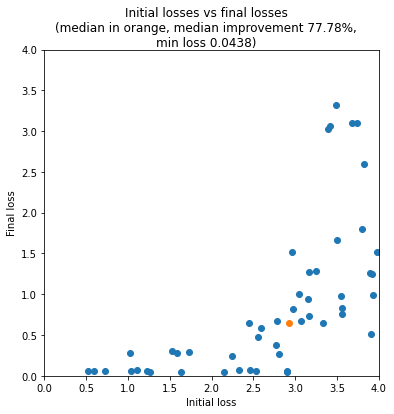

In [98]:
res_pkl_fn = os.path.join(dump_folder, f"variation_wo_divergence_2_all.pkl")
# results_vars = fancy_fit_2_variations(filename=""variation_wo_divergence_2_")
results_vars = load(res_pkl_fn)
plot_variation_results(results_vars)

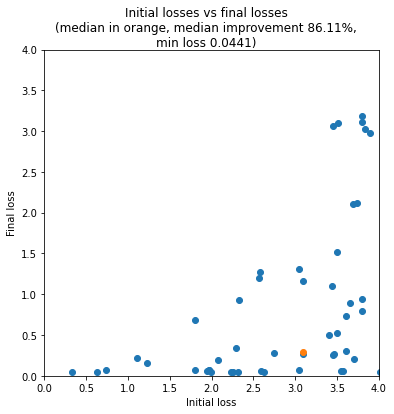

In [99]:
if False:
    results_vars_2 = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .8,
        iters = 20,
        filename = "variation_wo_divergence_3_"
        )
res_pkl_2_fn = os.path.join(dump_folder, f"variation_wo_divergence_3_all.pkl")
results_vars_2 = load(res_pkl_2_fn)
plot_variation_results(results_vars_2, lim=4)

We can see that the results were better with the arguments

    lr = 1e-1,
    lr_factor = .8,
    iters = 20,

Let's try and validate that by reoptimising with the same parameters. There seems to be some variation, but the results are mostly similar even up to `lr_factor` of `0.95`. For now, let's settle on the settings:

    lr = 1e-1,
    lr_factor = .9,
    iters = 40,

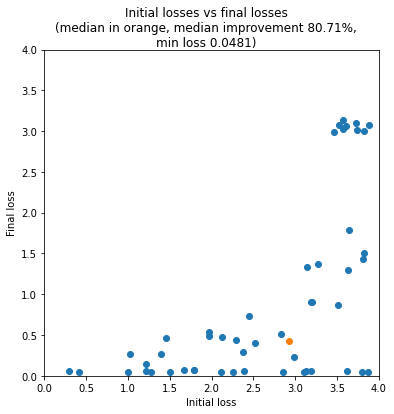

In [100]:
res_pkl_3_fn = "variation_wo_divergence_v4_"
if False:
    results_vars_3 = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .8,
        iters = 20,
        filename = res_pkl_3_fn
        )
results_vars_3 = load(os.path.join(dump_folder, f"{res_pkl_3_fn}all.pkl"))
plot_variation_results(results_vars_3, lim=4)

Let's complete a few more tests still. It seems we can increase `lr_factor` even more.

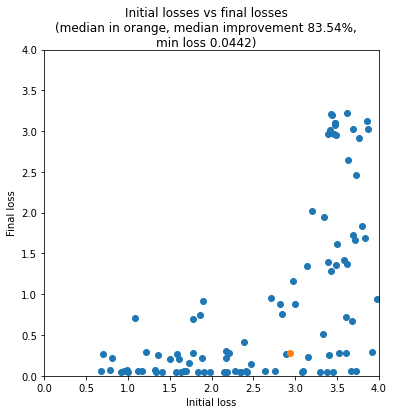

In [101]:
res_pkl_4_fn = "variation_wo_divergence_v5_"
if False:
    results_vars_4 = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .85,
        iters = 30,
        filename = res_pkl_4_fn,
        variations = 100,
        )
results_vars_4 = load(os.path.join(dump_folder, f"{res_pkl_4_fn}all.pkl"))
plot_variation_results(results_vars_4, lim=4)

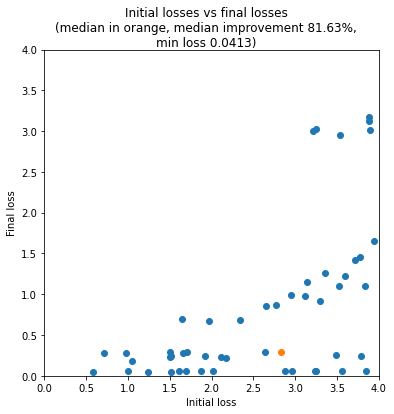

In [102]:
res_pkl_5_fn = "variation_wo_divergence_v6_"
if False:
    results_vars_5 = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .9,
        iters = 40,
        filename = res_pkl_5_fn,
        variations = 50,
        )
results_vars_5 = load(os.path.join(dump_folder, f"{res_pkl_5_fn}all.pkl"))
plot_variation_results(results_vars_5, lim=4)

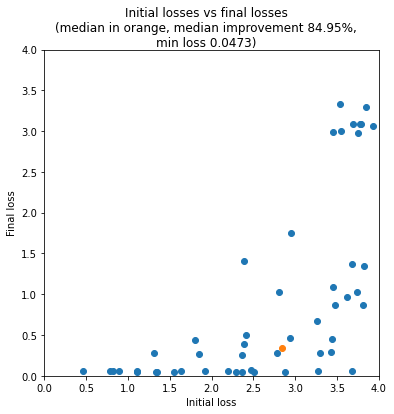

In [103]:
res_pkl_6_fn = "variation_wo_divergence_v7_"
if False:
    results_vars_6 = fancy_fit_2_variations(
        lr = 1e-1,
        lr_factor = .95,
        iters = 40,
        filename = res_pkl_6_fn,
        variations = 50,
        )
results_vars_6 = load(os.path.join(dump_folder, f"{res_pkl_6_fn}all.pkl"))
plot_variation_results(results_vars_6, lim=4)

Finally, let's have a look at combined statistics from all of these optimisation runs and the resultant fonts.

Total 350 • Loss < .05: 33 • Loss < .06: 89


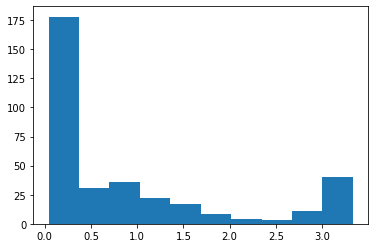

In [131]:
all_vars_df = DataFrame(results_vars + results_vars_2 + results_vars_3 + results_vars_4 + results_vars_5 + results_vars_6)
fl = all_vars_df.final_loss
print(f"Total {len(fl)} • Loss < .05: {len(fl[fl < .05])} • Loss < .06: {len(fl[fl < .06])}")
_ = plt.hist(fl)
sel_vars_df = all_vars_df[fl < .05].copy()
dump(sel_vars_df, VARS_WO_DIV_ADAM_PATH)
# plt.hist(all_vars_df[all_vars_df.final_loss < .05].final_loss)

Looking at the renderings we see that there's a lot of divergence even between these low-loss results.

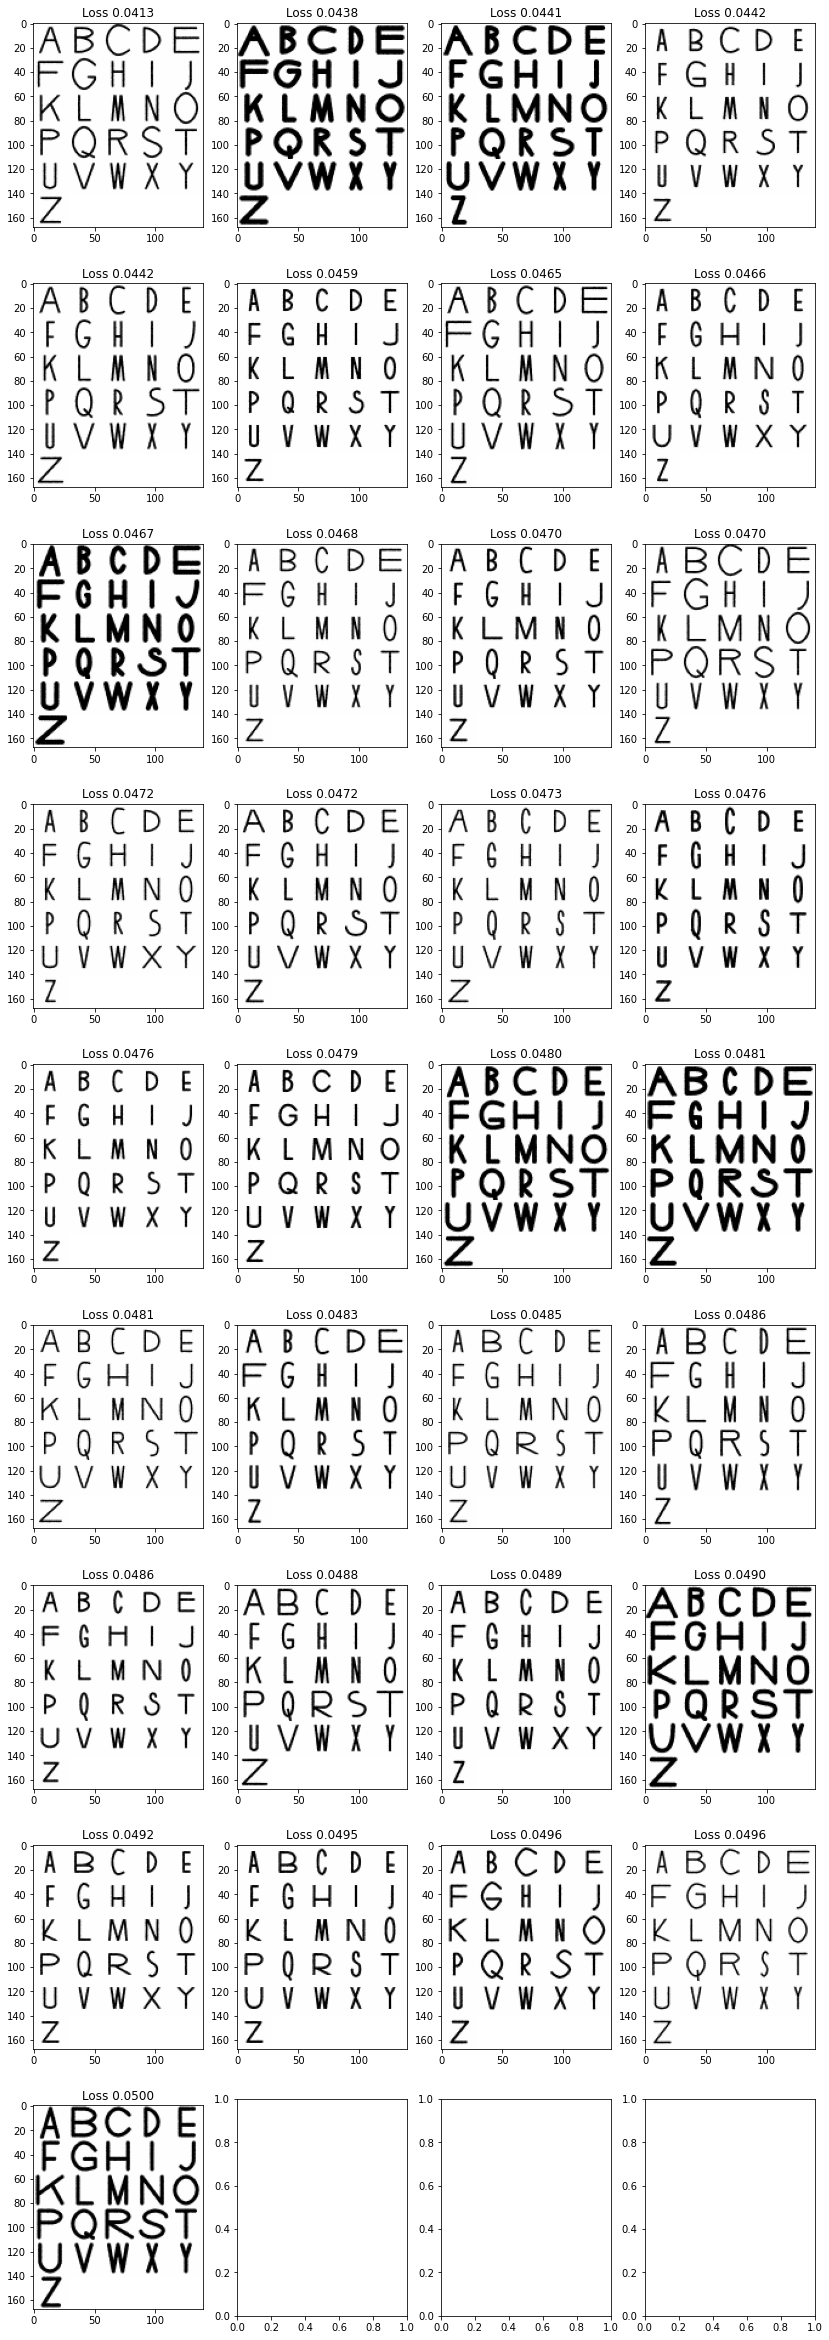

In [132]:
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)
fig = show_variation_renders(sel_vars_df)

## 6. See If We Can Use Naive Optimisation to Further Improve the Best Results

Based on the renderings above, it looks like we could get some improvements by tweaking individual parameters, especially those that only affect a few letters. However, running the rather slow naïve optimisation procedure didn't improve the results at all, but instead led to an impairment of .018. This is probably due to the large random jitter in the loss. See the next test for details.

In [5]:
sel_vars_df = load(VARS_WO_DIV_ADAM_PATH)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_15295/933257450.py:27: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


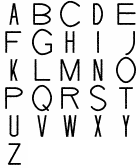

In [7]:
learner = get_learner()
i = 0
v = sel_vars_df.iloc[i]
learner.load_param_dict(v.final_params)
# impr, res = learner.fit_naively(iters=2, epochs=2)
# print(impr)
# if impr > 0:
#     display(v.img)
#     display(learner.render_letters())
v.img

## Export

In [5]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
